<a href="https://colab.research.google.com/github/Malvi-M/Semantic-Image-Segmentation-on-Urban-Streets/blob/main/UNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Loading and Preprocessing**

Image segmentation can be interpreted as a classification problem, where the task is to classify each pixel of the image into a particular class. To build an end-to-end pixel-to-pixel segmentation network, our model must be capable of extracting rich spatial information from the images. A typical CNN used for classification takes an image as input, passes it through a series of convolutional and pooling layers and uses fully-connected layers in the end to output a fixed length vector, thus discarding all the spatial information from the original image. For building our model, we have used the `cityscapes-image-pairs` dataset, containing 2975 images which are used for training and 500 images for validating the performance of our model.

**Importing the required libraries**



*   Numpy - for linear algebra
*   os - for receiving information about files
*   matplotlib - for visualizing
*   PIL and CV2 - for image loading and editing
*   scikit-learn KMeans - for color clustering
*   random - for generating random numbers and choices
*   keras - a high level interface to tensorflow (for neural networks)


In [ ]:
import numpy as np 
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
import keras.metrics

#### **Initialize Variables**

In [ ]:
train_folder="/content/drive/MyDrive/AI_Project/Image_Pairs/cityscapes_data/train"
valid_folder="/content/drive/MyDrive/AI_Project/Image_Pairs/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## **Helper Functions**


---


For preprocessing the dataset and defining the model, we have defined several helper functions -


* `LoadImage` - Loads a single image and its corresponding segmentation map, also allows simple Data Augmentation options such as flipping and rotating 
    * **Arguements** :
        * `name` - Name of the image file
        * `path` - Path to the image directory
        * `rotation` - Angle by which the image will rotate for Data Augmentation
        * `flip` - True/False
        * `size` - size of image
    * **Returns** - A tuple of 2 numpy arrays (image and segmentation map)



---


* `ColorToClass` - Converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation used for training our model
    * **Arguements** :
        * `seg` - Segmentation mask after clustering (width, height, 3) **(RGB)**
    * **Returns** - Categorical segmentation map (width, height, classes) 



---


* `LayersToRGBImage` - Converts the layer representation (categorical arrays) to a color representation for visualization 
    * **Arguements** :
        * `img` - Categorical segmented map (height, width, 13)
    * **Returns** - Colored segmentation map (width, height, 3) **(RGB)**


---


* `DataGenerator` - creates batches of e.g. 10 raw-segmented image pairs at a time, also uses image augmentation and randomly flips and rotates the images to increase the effective size of the dataset and returns data in form of batches  
    * **Arguements** :
        * `path` - location or path of the image directory
        * `batch_size` - size of each batch
        * `maxangle` -  angle to rotate image
    * **Returns** - Tuple of `batch_size` number of images and segmentation maps


---







* `UNet` - Creates the UNET model
    * **Returns** - UNet model




---










#### **LoadImage**


In [ ]:
def LoadImage(name, path=train_folder,
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 256)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

#### **Color Clustering**


In [ ]:
files =os.listdir(train_folder)[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(n_clusters=13, random_state=42)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

#### **Colors to Class**


In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

#### **Layers to RGB Image**



In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

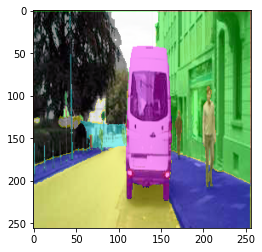

In [ ]:
img, seg = LoadImage("111.jpg")                     ## img = (200, 256, 3) && seg = (200, 256, 3)
seg2 = ColorsToClass(seg)                           ## seg2 = (200, 256, 13)
seg2 = LayersToRGBImage(seg2)                       ## seg2 = (200, 256, 3)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)     ## total = (200, 256, 3)
plot.imshow(total[:,:,:])
plot.show()

####  **Data Generator**



In [ ]:
def DataGenerator(path=train_folder, batch_size=10, maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)

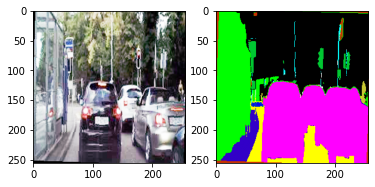

In [ ]:
gen = DataGenerator()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()


## **The Convolutional Neural Network - UNet**

UNet is a special kind of CNN, which uses concatenate layers to feed data from previous layers to the layers close to the output. The network has a double-funnel shape. The through feeding of data makes sure that no data is lost. Otherwise the funnel shape would cause something similar to an autoencoder.

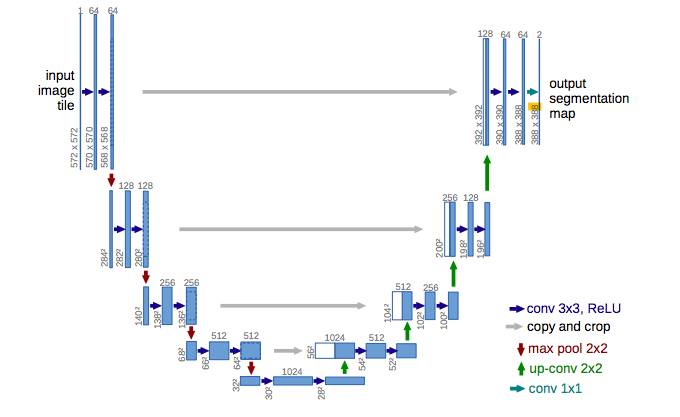

In [ ]:
def UNet():
    inp = Input(shape=(256, 256, 3))

    x1 = BatchNormalization()(inp)
    x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
    x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
    p1 = MaxPooling2D()(x1)
    #p1 = Dropout(0.2)(p1)

    #x2 = BatchNormalization()(x1)
    x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
    x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
    p2 = MaxPooling2D()(x2)
    #p2 = Dropout(0.2)(p2)

    #x3 = BatchNormalization()(x2)
    x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
    x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
    p3 = MaxPooling2D()(x3)
    #p3 = Dropout(0.2)(p3)

    #x4 = BatchNormalization()(x3)
    x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
    x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
    #x4 = MaxPooling2D()(x4)
    #x4 = Dropout(0.2)(x4)

    x5 = UpSampling2D()(x4)
    x5 = concatenate([x3, x5])
    x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
    x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
    #x5 = Dropout(0.2)(x5)

    x6 = UpSampling2D()(x5)
    x6 = concatenate([x2, x6])
    x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
    x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
    #x6 = Dropout(0.2)(x6)

    x7 = UpSampling2D()(x6)
    x7 = concatenate([x1, x7])
    x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
    x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)

    model = Model(inp, x7)
    return model

In [ ]:
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 1179776     conv2d[0][0]                     
______________________________________________________________________________________________

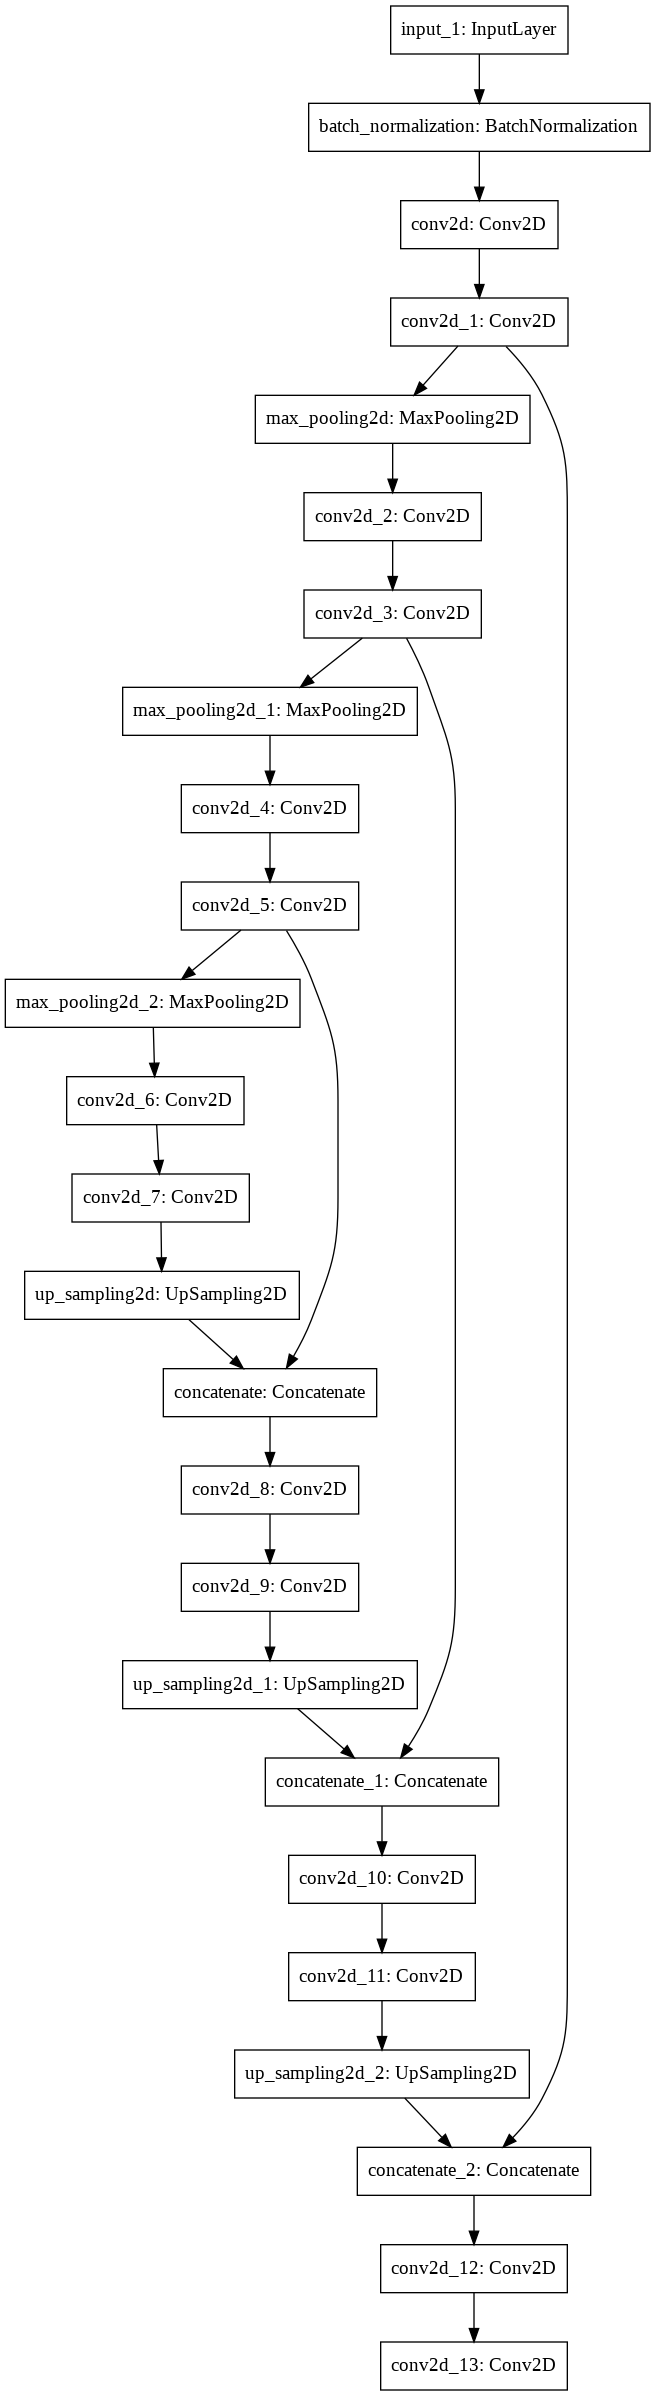

In [ ]:
plot_model(model)

In [ ]:
train_gen = DataGenerator()
val_gen = DataGenerator(valid_folder)

## **Training**

Trained for 1000 epochs and use a Model Checkpoint to save the model with the smallest validation loss.

In [ ]:
## adam = Adam(lr=0.0001, decay=1e-06)
## model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
## checkpoint_filepath = 'UNet_loss.h5'
## clb = [ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, verbose=0)]

In [ ]:
## h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,validation_data=val_gen, validation_steps=10,callbacks=clb, verbose=1)

Save the model and load the best model from the training run.

In [ ]:
## model.save("UNet_model.h5")
## model = load_model("UNET_model.h5")

In [ ]:
## loss = h.history["val_loss"]
## acc = h.history["val_acc"]
## 
## plot.figure(figsize=(12, 6))
## plot.subplot(211)
## plot.title("Val. Loss")
## plot.plot(loss)
## plot.xlabel("Epoch")
## plot.ylabel("Loss")
## 
## plot.subplot(212)
## plot.title("Val. Accuracy")
## plot.plot(acc)
## plot.xlabel("Epoch")
## plot.ylabel("Accuracy")
## 
## plot.tight_layout()
## plot.savefig("UNet_learn.png", dpi=150)
## plot.show()

##**The Results**

Visualizing how the CNN performs at the example of a few validation images

In [ ]:
model = load_model('UNet_model.h5')

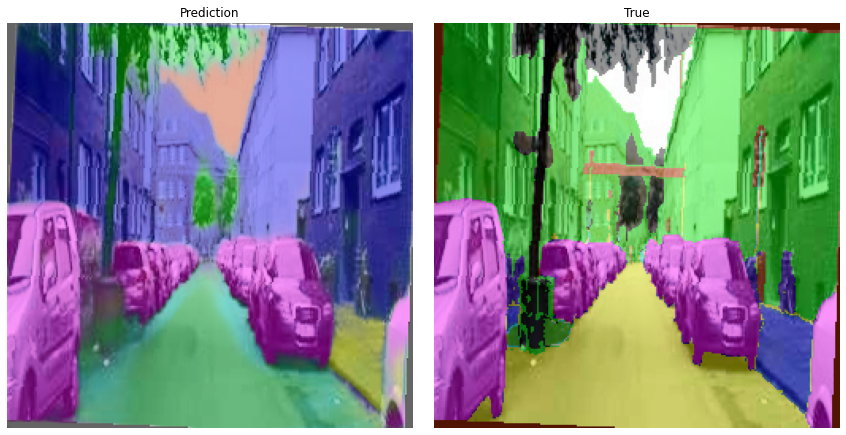

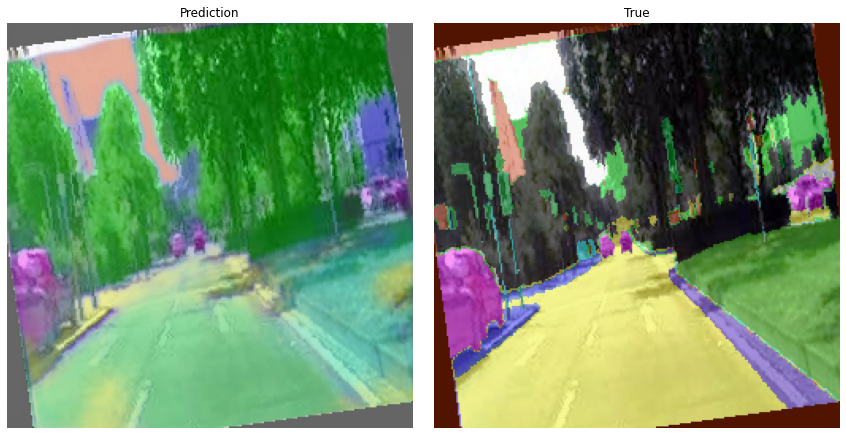

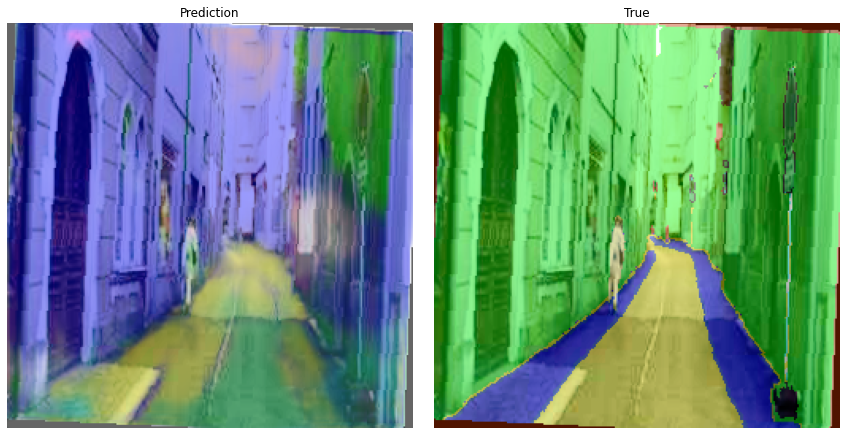

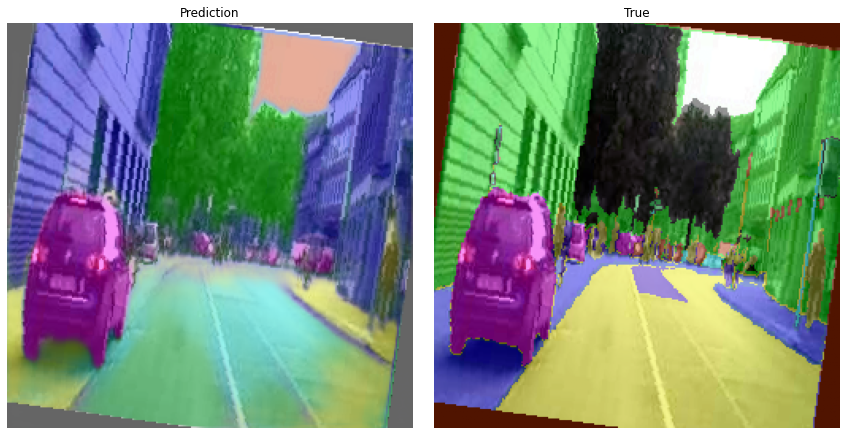

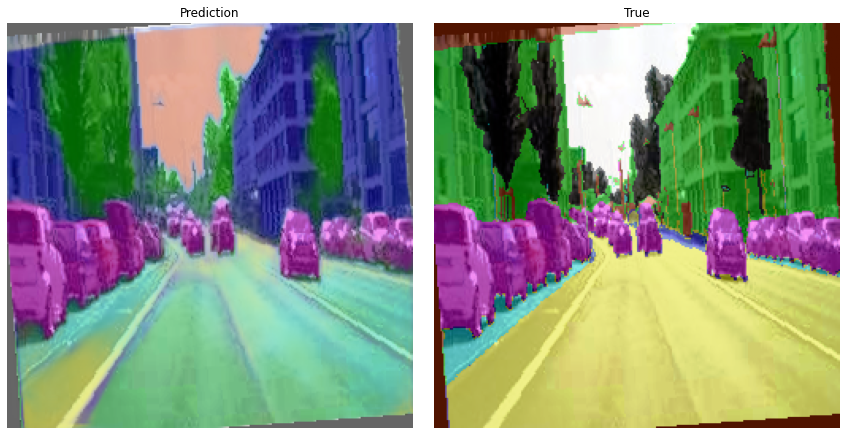

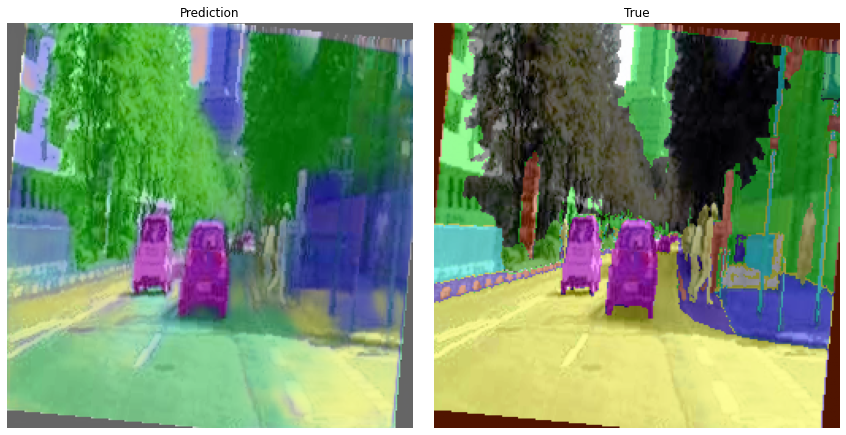

In [ ]:
test_gen = DataGenerator(valid_folder)
max_show=5
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(6,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

Plotting ROC_Curve for each class and calculating Balanced Accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


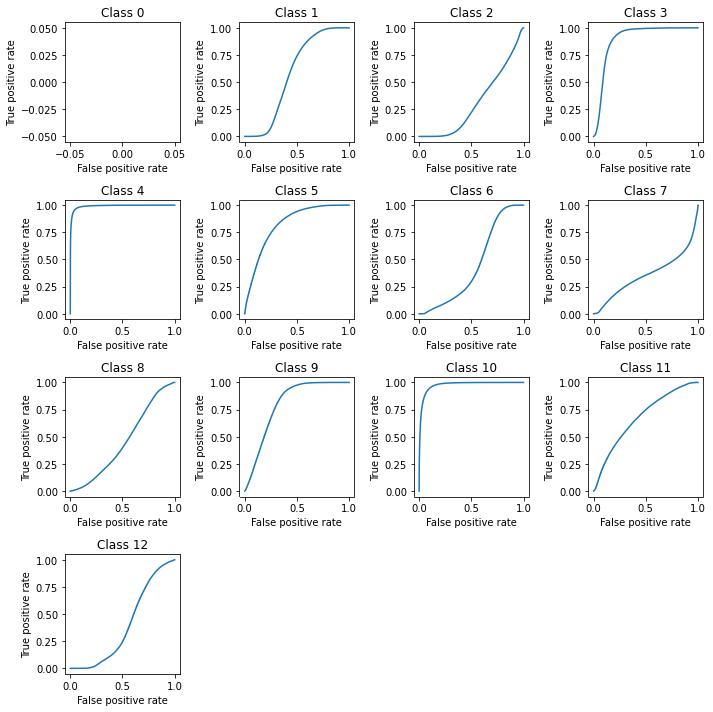

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = DataGenerator(valid_folder, batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

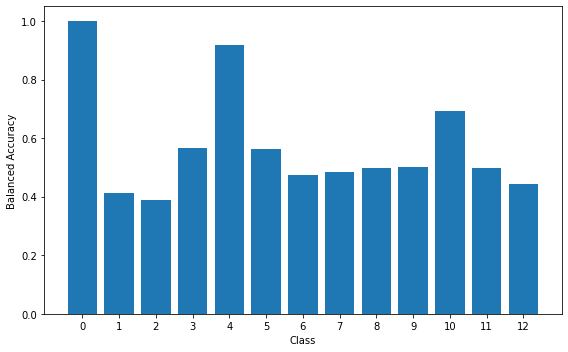

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("UNet_BalAcc.png")
plot.show()

Calculating Mean IoU (Intersection over Union) using sklearn's `jaccard_similarity_score`

Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in `y_true`

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


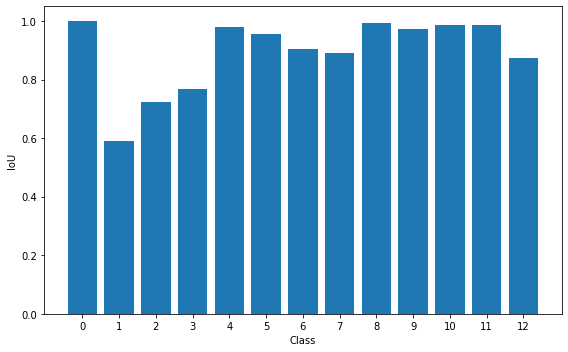

In [ ]:
from sklearn.metrics import jaccard_similarity_score 

test_gen = DataGenerator(valid_folder, batch_size=200)

for imgs, segs in test_gen:
  p = model.predict(imgs)  
  IoU = []
  for i in range(p.shape[-1]):
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        iou = jaccard_similarity_score(segs[:,:,:,i].ravel(), _p)
        IoU.append(iou)
  break

plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(IoU)), IoU)
plot.xticks(np.arange(0, len(IoU)))
plot.ylabel("IoU")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("UNet_mIoU.png")
plot.show()